<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Trabajando con _autoencoders_<a id="top"></a>

<i><small>Autor: Alberto Díaz Álvarez<br>Última actualización: 2023-03-29</small></i></div>
                                                  

***

## Introducción

Los _autoencoders_ son una técnica de aprendizaje automático que se utilizan para codificar y decodificar datos. En esencia, son una arquitectura de red neuronal cuyo objetivo es tomar una entrada de datos, comprimirla en un espacio de menor dimensión o espacio latente, y luego reconstruirla lo más fiel posible a la entrada original a partir de dicho espacio latente.

## Objetivos

Implementaremos dos autoencoders para el problema `mnist`:

1. Uno muy sencillo que constará de únicamente la capa de entrada, la capa de salida y la capa intermedia que representará el espacio latente. Evidentemente se necesitan dos operaciones a aplanamiento y reconstrucción, pero hablamos de capas que contienen información.
2. Otro algo más complejo que estará diseñado específicamente para imágenes, y que por tanto usará convoluciones para la codificación y reconstrucción.

## Imports y configuración

A continuación importaremos las librerías que se usarán a lo largo del notebook.

In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

Configuraremos también algunos parámetros para adecuar la presentación gráfica.

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Conjunto de datos

Vamos a trabajar con el conjunto de datos `mnist` ya que lo conocemos bastante bien.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255, x_test / 255

print(f'Training shape: {x_train.shape} input, {y_train.shape} output')
print(f'Test shape:     {x_test.shape} input, {y_test.shape} output')

Training shape: (60000, 28, 28) input, (60000,) output
Test shape:     (10000, 28, 28) input, (10000,) output


Ahora ya podemos a empezar a trabajar con _autoencoders_ para aprender cómo se usan y su potencialidad.

## Autoencoder básico

En este primer ejemplo, vamos a crear un autoencoder muy simple donde la parte codificadora será una capa densa que conectará la entrada con el espacio latente y donde la decodificadra hará justo lo contrario, conectar la capa latente con la capa de salida.

Al estar trabajando con imágenes de $28 \times 28$, tendremos que jugar a aplanar y reconstruir la entrada antes de entrar y salida a y desde esas capas, pero eso no tiene misterio.

Aprovecharemos y crearemos el autoencoder como una clase `Model`. Hasta ahora hemos creado modelos indicando entradas y salidas definidas fuera de su _scope_. De esta manera podemos tener nuestros modelos como clases que podemos reutilizar más fácilmente.

In [4]:
class Autoencoder(tf.keras.models.Model):
    """Representa un autoencoder simple"""
    def __init__(self, input_dim, latent_dim):
        super().__init__()

        flatten_dim = None
        if isinstance(input_dim, (list, tuple)):
            flatten_dim = math.prod(input_dim)
        elif isinstance(input_dim, int):
            flatten_dim = input_dim
            input_dim = (input_dim,)
        else:
            raise ValueError('Argument input_dim must be a tuple or an int')
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim, activation=tf.keras.layers.LeakyReLU()),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(flatten_dim, activation='sigmoid'),
            tf.keras.layers.Reshape(input_dim)
        ])

    def call(self, x):
        return self.decoder(self.encoder(x))

Ahora podemos usar este modelo para crear un autoencoder:

In [5]:
autoencoder = Autoencoder(input_dim=(28, 28), latent_dim=64)

Vamos a entrenar nuestro autoencoder con el conjunto de entrenamiento de  `mnist`. Como es un modelo, tenemos que compilarlo previamente especificando qué función de _loss_ y qué optiizador vamos a usar. También podremos invocar los métodos de modelo en él, como `fit`.

In [6]:
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
history = autoencoder.fit(x_train, x_train, epochs=50)

Epoch 1/50
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1418
Epoch 2/50
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0836
Epoch 3/50
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0770
Epoch 4/50
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0752
Epoch 5/50
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0746
Epoch 6/50
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0742
Epoch 7/50
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0740
Epoch 8/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0739
Epoch 9/50
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0737
Epoch 10/50
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0737
Epoch 11/50
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0736
Epoch 12/50
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0735
E

Veamos cómo ha evolucinado el entrenamiento:

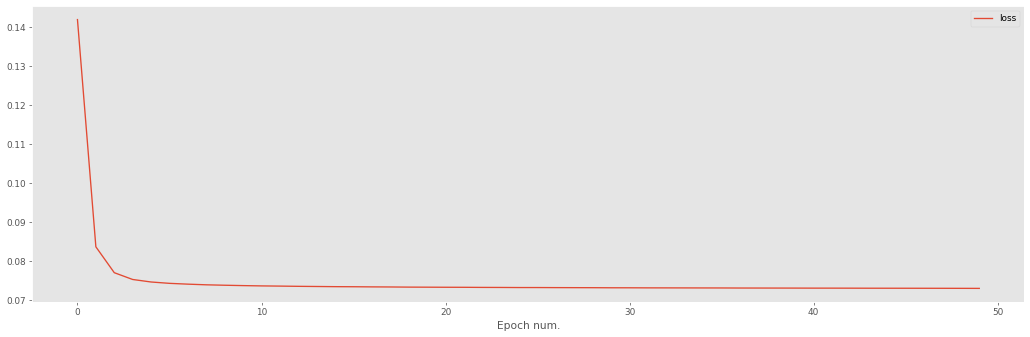

In [7]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

El entrenamiento tiene bastante buena pinta. Veamos cómo se codifican y decodifican algunos ejemplos del conjunto de entrenamiento.

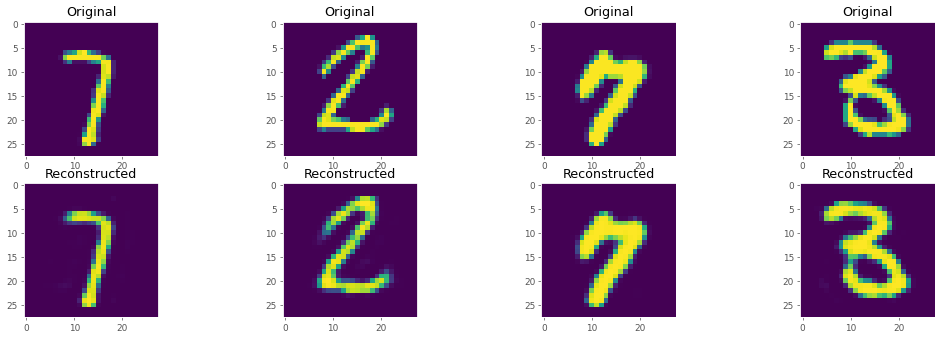

In [8]:
n = 4
images = np.array(random.sample(list(x_train), n))

encoded = autoencoder.encoder(images).numpy()
decoded = autoencoder.decoder(encoded).numpy()
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title('Original')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded[i])
    plt.title('Reconstructed')

Ahora veamos con datos que no ha visto nunca

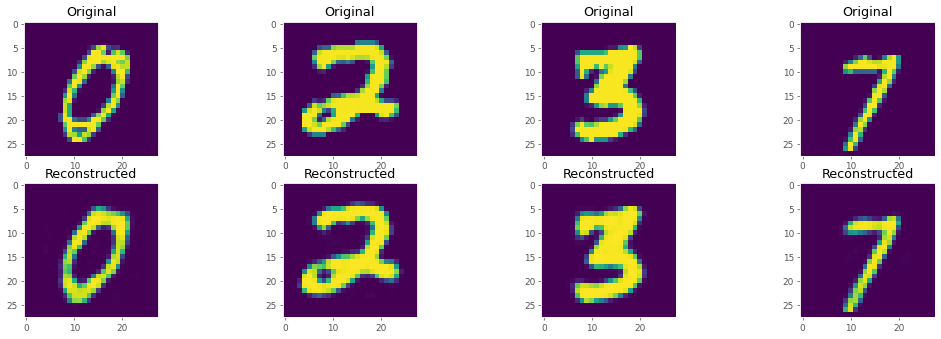

In [9]:
images = np.array(random.sample(list(x_test), n))
encoded = autoencoder.encoder(images).numpy()
decoded = autoencoder.decoder(encoded).numpy()
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title('Original')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded[i])
    plt.title('Reconstructed')

## Autoencoder convolucional

En este segundo ejemplo complicaremos (un poco) el primer ejemplo, realizando la codificación con capas convolucionales en lugar de capas densas.

Podríamos usar una red convolucional completa, pero nos vamos a limitar al uso de convoluciones para hacer el downsampling/upsampling aprovechando que el problema a resolver trata con imágenes.

In [10]:
class ConvolutionalAutoencoder(tf.keras.models.Model):
    """Representa un autoencoder simple"""
    def __init__(self):
        super().__init__()
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Convolution2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((4, 4))
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Convolution2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((4, 4)),
            tf.keras.layers.Convolution2D(1, (3, 3), activation='sigmoid', padding='same'),
        ])

    def call(self, x):
        if len(x.shape) == 3:
            # Nos viene (BATCH, ROWS, COLS), hay que añadir la dimensión "CHANNEL"
            x = tf.expand_dims(x, axis=-1)
        return self.decoder(self.encoder(x))

Creamos un nuevo modelo a partir de la clase definida:

In [11]:
conv_autoencoder = ConvolutionalAutoencoder()

Y entrenamos este encoder igual que entrenamos el anterior. Ojo, este entrenamiento puede tardar **mucho**, así que podemos, o bien creernos que va a funcionar, o bien lanzarlo en una máquina diferente

In [12]:
conv_autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
history = conv_autoencoder.fit(x_train, x_train, epochs=25)

Epoch 1/25
1875/1875 [==============================] - 44s 23ms/step - loss: 0.1184
Epoch 2/25
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0972
Epoch 3/25
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0951
Epoch 4/25
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0940
Epoch 5/25
1875/1875 [==============================] - 44s 24ms/step - loss: 0.0933
Epoch 6/25
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0928
Epoch 7/25
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0925
Epoch 8/25
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0923
Epoch 9/25
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0921
Epoch 10/25
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0919
Epoch 11/25
1875/1875 [==============================] - 42s 23ms/step - loss: 0.0918
Epoch 12/25
1875/1875 [==============================] - 43s 23

Veamos cómo ha evolucinado el entrenamiento:

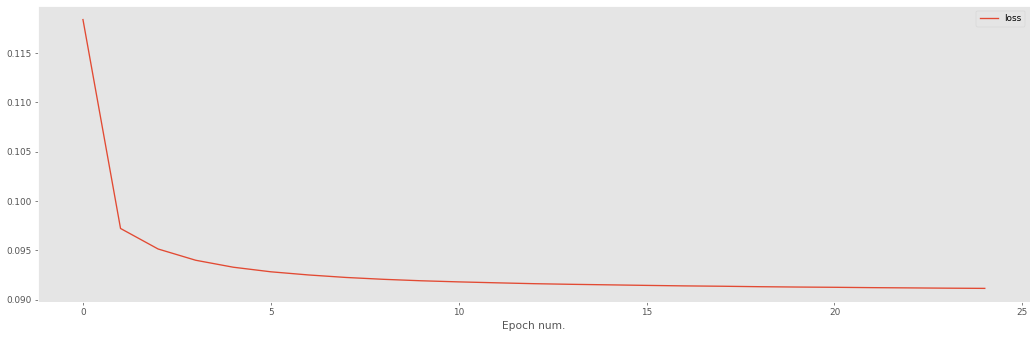

In [13]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

El entrenamiento tiene bastante buena pinta. Veamos cómo se codifican y decodifican algunos ejemplos del conjunto de entrenamiento.

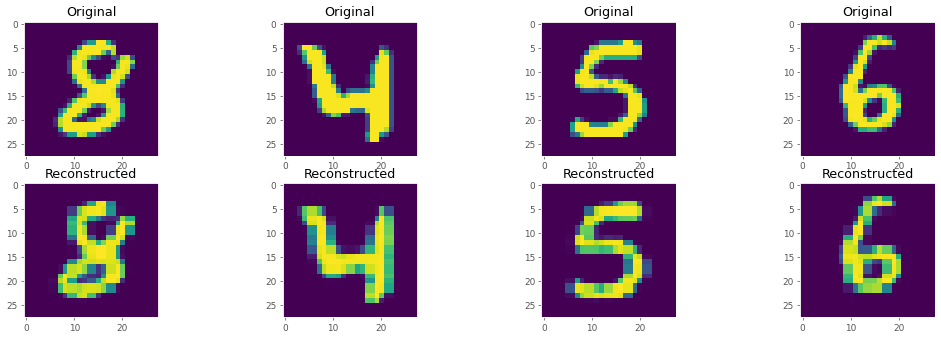

In [14]:
images = np.array(random.sample(list(x_train), n))

encoded = conv_autoencoder.encoder(images).numpy()
decoded = conv_autoencoder.decoder(encoded).numpy()
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title('Original')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded[i])
    plt.title('Reconstructed')

Ahora veamos con datos que no ha visto nunca

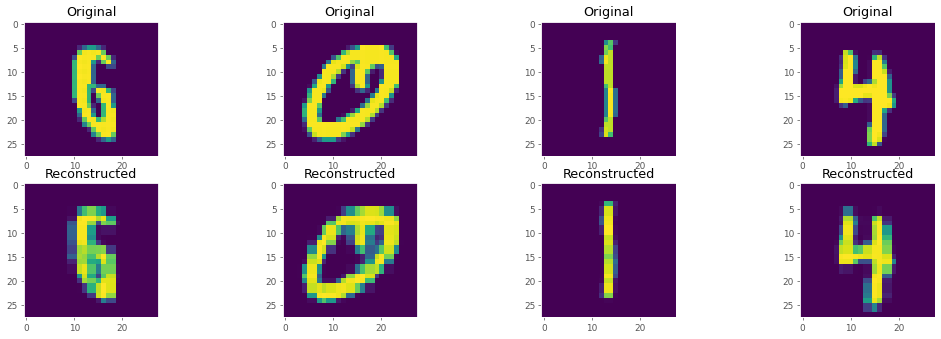

In [15]:
images = np.array(random.sample(list(x_test), n))
encoded = conv_autoencoder.encoder(images).numpy()
decoded = conv_autoencoder.decoder(encoded).numpy()
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title('Original')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded[i])
    plt.title('Reconstructed')

## Caso de uso: Eliminación de ruido

Una de las utilidades de los autoencode es la de la eliminación de ruido. Una vez ha aprendido las características fundamentales desde las que reconstruir las imágenes, es capaz de sobreponerse al ruido obviandolo en la codificación.

Vamos a tomar de nuevo algunas imágenes del conjunto de test, porque son las que no ha visto nunca, y vamos a añadirlas algo de ruido para ver cómo es capaz de extraer la imagen original casi sin ruido.

In [16]:
images = np.array(random.sample(list(x_test), n))
noise_factor = 0.3
noisy_images = images + noise_factor * tf.random.normal(shape=images.shape)
noisy_images = tf.clip_by_value(noisy_images, clip_value_min=0, clip_value_max=1)

Ahora veamos cómo regenera las imágenes con ruido

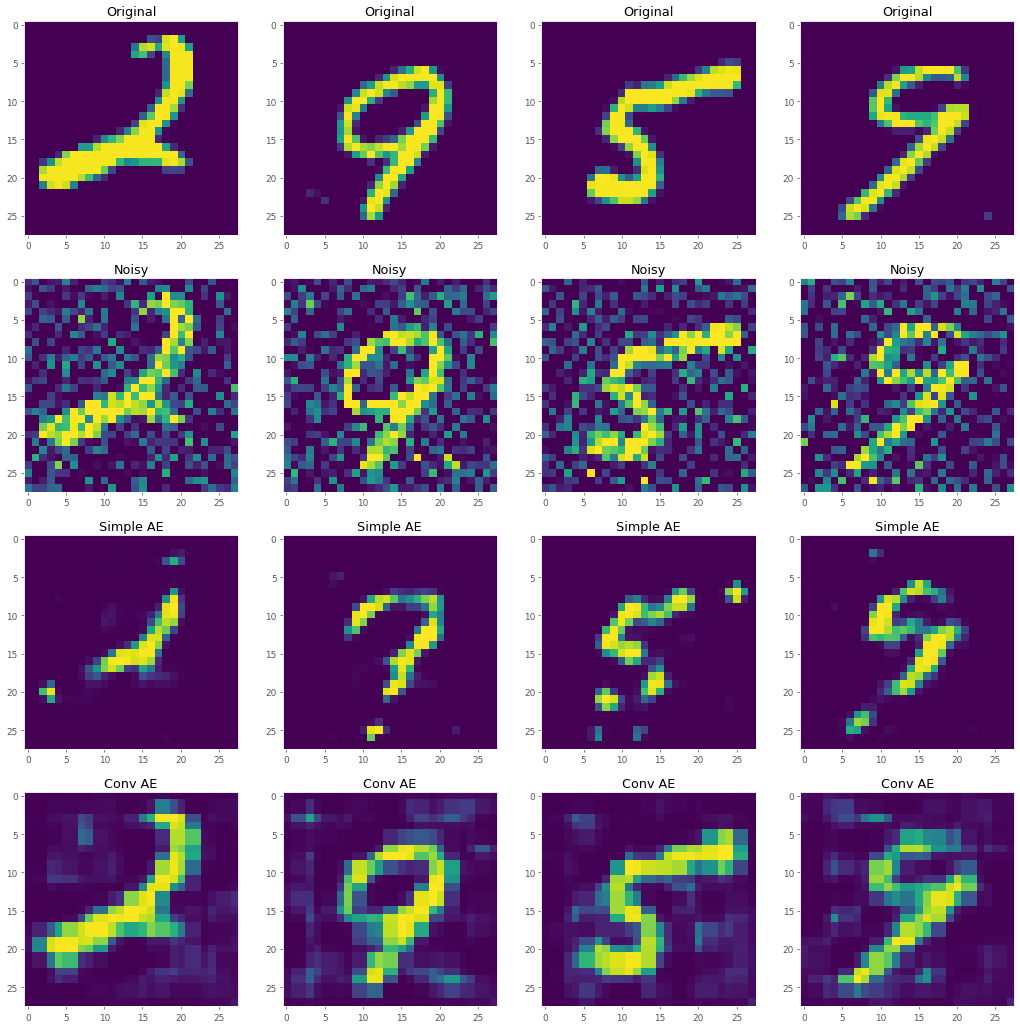

In [17]:
simple_decoded = autoencoder.decoder(autoencoder.encoder(noisy_images)).numpy()
conv_decoded = conv_autoencoder.decoder(conv_autoencoder.encoder(noisy_images)).numpy()

plt.figure(figsize=(20,20)) 
for i in range(n):
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(images[i])
    plt.title('Original')

    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(noisy_images[i])
    plt.title('Noisy')

    ax = plt.subplot(4, n, i + 1 + 2 * n)
    plt.imshow(simple_decoded[i])
    plt.title('Simple AE')

    ax = plt.subplot(4, n, i + 1 + 3 * n)
    plt.imshow(conv_decoded[i])
    plt.title('Conv AE')

## Conclusiones

Los autoencoders son una herramienta muy útil y versátil en el campo del aprendizaje automático y la inteligencia artificial. Son capaces de aprender patrones complejos en los datos, comprimirlos en un espacio de menor dimensión y luego reconstruirlos con una alta precisión. Además, son muy adaptables y pueden ser ajustados y entrenados para una gran variedad de aplicaciones.

Sin embargo, es importante tener en cuenta que los autoencoders tienen algunas limitaciones. Uno de los principales desafíos es la selección del tamaño adecuado del espacio de codificación, ya que un espacio demasiado pequeño puede resultar en una pérdida de información, mientras que uno demasiado grande puede ser ineficiente. Además, en algunos casos, los autoencoders pueden ser susceptibles a sobreajuste y deben ser ajustados cuidadosamente.

En general, son una herramienta valiosa para almacenar en nuestra caja de herramientas de aprendizaje automático.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>